# **Measuring how Frozen & Imbalanced the Job Market is** 
## (01-03-2006 to 03-01-2025)


# DERIVED FEATURES

### 📊 **Derived Metrics to Compare Supply vs. Demand**

---

| Feature Name                 | Equation                                               | Interpretation                        | Why It Matters                                                       | Supply or Demand |
| ---------------------------- | ------------------------------------------------------ | ------------------------------------- | -------------------------------------------------------------------- | ---------------- |
| OpeningsPerUnemployed        | Job\_Openings\_Rate / Unemployment\_Level              | Openings per unemployed person        | Signals labor tightness or slack                                     | Demand           |
| OpeningsPerHire              | Job\_Openings\_Rate / Hires\_Rate                      | Openings per hire                     | High values imply hiring friction or mismatch                        | Demand           |
| HiresPerUnemployed           | Hires\_Rate / Unemployment\_Level                      | Hires per unemployed person           | Indicates efficiency of unemployed absorption                        | Demand           |
| QuitsPerUnemployed           | Quits\_Rate / Unemployment\_Level                      | Quits per unemployed person           | Reflects worker confidence in finding new jobs                       | Supply           |
| LayoffsPerOpening            | Layoffs\_and\_Discharges / Job\_Openings\_Rate         | Layoffs per opening                   | High values imply instability or contradictory signals               | Supply           |
| QuitsPerLayoffs              | Quits\_Rate / Layoffs\_and\_Discharges                 | Voluntary vs involuntary separations  | Indicates whether workers are confident or being forced out          | Supply           |
| NILFWJNPerPop                | Not\_In\_Labor\_Force\_WantAJobNow / Total\_Population | Hidden unemployed in total population | Captures discouraged workers not counted in official stats           | Supply           |
| MarginallyAttachedPerNILF    | Marginally\_Attached\_Workers / Not\_in\_Labor\_Force  | Share of NILF willing to work         | Signals potential re-entry into workforce                            | Supply           |
| CPIYOY                       | CPI.pct\_change(12) \* 100                             | Year-over-year inflation              | Tracks price pressure impacting wages and hiring                     | Demand           |
| TempHelpEmploymentYoY        | Temp\_Help\_Services.pct\_change(12) \* 100            | YoY growth of temp jobs               | Leading indicator of labor demand swings                             | Demand           |
| AvgWeeklyEarningYoY          | Avg\_Weekly\_Earning.pct\_change(12) \* 100            | Nominal earnings growth               | High growth indicates wage pressure or labor bargaining power        | Demand           |
| RealAvgWeeklyEarningsYoY     | AvgWeeklyEarningYoY - CPIYOY                           | Real wage growth (inflation-adjusted) | Indicates actual purchasing power of workers                         | Supply           |
| U6\_U3\_Spread               | U6\_Unemployment\_Rate - U3\_Unemployment\_Rate        | Underemployment spread                | Captures hidden slack beyond official unemployment                   | Supply           |
| HourlyEarningsEstimate       | Average\_Weekly\_Earnings / Average\_Weekly\_Hours     | Implied average hourly compensation   | Normalizes earnings for hours worked; purer measure of wage pressure | Demand           |
| ApplicantsPerJobProxy | Unemployment\_Level / Job\_Openings\_Rate              | Job seekers per opening (congestion)  | Higher values = more labor supply pressure per available job         | Supply           |

---


In [9]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames

Layoffs_df = pd.read_csv('Demand_vs_Supply/Layoffs.csv')
Total_Seperations_df = pd.read_csv('Demand_vs_Supply/Total_Seperations.csv')
Temp_Help_Employment_df = pd.read_csv('Demand_vs_Supply/Temporary_Help_Services_Employment.csv')
Avg_Weekly_Earnings_df = pd.read_csv('Demand_vs_Supply/Average_Weekly_Earnings.csv')
Avg_Weekly_Hours_df = pd.read_csv('Demand_vs_Supply/Average_Weekly_Hours.csv')
Median_Hourly_Wage_Growth_df = pd.read_csv('Demand_vs_Supply/Median_Hourly_Wage_Growth.csv')
Total_Pop_df = pd.read_csv('Demand_vs_Supply/Total_Population.csv')
Not_in_Labor_Force_df = pd.read_csv('Demand_vs_Supply/Not_in_Labor_Force.csv')
U6_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U6_Unemployment_Rate.csv')
U3_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U3_Unemployment_Rate.csv')
U2_Unempoyment_df = pd.read_csv('Demand_vs_Supply/U2_Unemployment_Rate.csv')
Unemployment_Level_df = pd.read_csv('Demand_vs_Supply/Unemployment_Level.csv')
Prime_Employment_to_Pop_Ratio_df = pd.read_csv('Demand_vs_Supply/Prime_Employment_to_Population_Ratio.csv')
CPI_df = pd.read_csv('Demand_vs_Supply/CPI.csv')
Median_Weeks_Unemployed_df= pd.read_csv('Demand_vs_Supply/Median_Weeks_Unemployed.csv')
Initial_Jobless_Claims_df = pd.read_csv('Demand_vs_Supply/Initial_Jobless_Claims.csv')
Job_Openings_Rate_df = pd.read_csv('Demand_vs_Supply/Job_Openings_Rate.csv')
Quits_Rate_df = pd.read_csv('Demand_vs_Supply/Quits_Rate.csv')
Unemployment_Level_df = pd.read_csv('Demand_vs_Supply/Unemployment_Level.csv')
Hires_Rate_df = pd.read_csv('Demand_vs_Supply/Hires_Rate.csv')
NILFWJN_df = pd.read_csv('Demand_vs_Supply/NILFWJN.csv')
Not_in_Labor_Force_df = pd.read_csv('Demand_vs_Supply/Not_in_Labor_Force.csv')
Marginally_Attached_df = pd.read_csv('Demand_vs_Supply/Marginally_Attached.csv')
Involuntary_Part_Time_df = pd.read_csv('Demand_vs_Supply/Involuntary_Part_Time.csv')



# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Layoffs_df.to_sql('Layoff', conn, index=False, if_exists='replace')
Total_Seperations_df.to_sql('Seperation', conn, index=False, if_exists='replace')
Temp_Help_Employment_df.to_sql('Temp_Help', conn, index=False, if_exists='replace')
Avg_Weekly_Earnings_df.to_sql('Weekly_Earning', conn, index=False, if_exists='replace')
Avg_Weekly_Hours_df.to_sql('Weekly_Hours', conn, index=False, if_exists='replace')
Median_Hourly_Wage_Growth_df.to_sql('Median_Wage_Growth', conn, index=False, if_exists='replace')
Total_Pop_df.to_sql('Population', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('NILF', conn, index=False, if_exists='replace')
U6_Unempoyment_df.to_sql('U6', conn, index=False, if_exists='replace')
U3_Unempoyment_df.to_sql('U3', conn, index=False, if_exists='replace')
U2_Unempoyment_df.to_sql('U2', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployment_Level', conn, index=False, if_exists='replace')
Prime_Employment_to_Pop_Ratio_df.to_sql('Prime_ETPR', conn, index=False, if_exists='replace')
CPI_df.to_sql('CPI', conn, index=False, if_exists='replace')
Median_Weeks_Unemployed_df.to_sql('Median_Weeks_Unemployed', conn, index=False, if_exists='replace')
Initial_Jobless_Claims_df.to_sql('Initial_Claims', conn, index=False, if_exists='replace')
Job_Openings_Rate_df.to_sql('Job_Openings', conn, index=False, if_exists='replace')
Quits_Rate_df.to_sql('Quits', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployment', conn, index=False, if_exists='replace')
Hires_Rate_df.to_sql('Hires', conn, index=False, if_exists='replace')
NILFWJN_df.to_sql('NILFWJN', conn, index=False, if_exists='replace')
Not_in_Labor_Force_df.to_sql('Not_in_Labor_Force', conn, index=False, if_exists='replace')
Marginally_Attached_df.to_sql('Marginally_Attached', conn, index=False, if_exists='replace')
Involuntary_Part_Time_df.to_sql('Involuntary_Part_Time', conn, index=False, if_exists='replace')





# SQL query to merge all tables on 'Player'
sql_query = """
SELECT *
FROM Weekly_Hours
JOIN Layoff ON Weekly_Hours.observation_date = Layoff.observation_date
JOIN Job_Openings ON Weekly_Hours.observation_date = Job_Openings.observation_date
JOIN Quits ON Weekly_Hours.observation_date = Quits.observation_date
JOIN Unemployment ON Weekly_Hours.observation_date = Unemployment.observation_date
JOIN Hires ON Weekly_Hours.observation_date = Hires.observation_date
JOIN Seperation ON Weekly_Hours.observation_date = Seperation.observation_date
JOIN Temp_Help ON Weekly_Hours.observation_date = Temp_Help.observation_date
JOIN Weekly_Earning ON Weekly_Hours.observation_date = Weekly_Earning.observation_date
JOIN Median_Wage_Growth ON Weekly_Hours.observation_date = Median_Wage_Growth.observation_date
JOIN Population ON Weekly_Hours.observation_date = Population.observation_date
JOIN NILF ON Weekly_Hours.observation_date = NILF.observation_date
JOIN U6 ON Weekly_Hours.observation_date = U6.observation_date
JOIN U3 ON Weekly_Hours.observation_date = U3.observation_date
JOIN U2 ON Weekly_Hours.observation_date = U2.observation_date
JOIN Prime_ETPR ON Weekly_Hours.observation_date = Prime_ETPR.observation_date
JOIN CPI ON Weekly_Hours.observation_date = CPI.observation_date
JOIN Median_Weeks_Unemployed ON Weekly_Hours.observation_date = Median_Weeks_Unemployed.observation_date
JOIN Initial_Claims ON Weekly_Hours.observation_date = Initial_Claims.observation_date
JOIN NILFWJN ON Weekly_Hours.observation_date = NILFWJN.observation_date
JOIN Not_in_Labor_Force ON Weekly_Hours.observation_date = Not_in_Labor_Force.observation_date
JOIN Marginally_Attached ON Weekly_Hours.observation_date = Marginally_Attached.observation_date
JOIN Involuntary_Part_Time ON Weekly_Hours.observation_date = Involuntary_Part_Time.observation_date

"""


# Execute the query and load results into a DataFrame
Supply_Demand_Indicators_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user

Supply_Demand_Indicators_df

,observation_date,Avg_Weekly_Hours,observation_date,Layoffs_and_Discharges,observation_date,Job_Openings_Rate,observation_date,Quits_Rate,observation_date,Unemployment_Level,...,observation_date,InitialJoblessClaims,observation_date,Not_In_Labor_Force_WantAJobNow,observation_date,Not_in_Labor_Force,observation_date,Marginally_Attached_Workers,observation_date,Involuntary_Part_Time
0,2006-03-01,34.2,2006-03-01,1888,2006-03-01,5524,2006-03-01,2956,2006-03-01,7072,...,2006-03-01,301750.0,2006-03-01,4918,2006-03-01,77161,2006-03-01,451,2006-03-01,3972
1,2006-04-01,34.3,2006-04-01,1853,2006-04-01,5215,2006-04-01,2778,2006-04-01,7120,...,2006-04-01,303600.0,2006-04-01,4719,2006-04-01,77318,2006-04-01,381,2006-04-01,3900
2,2006-05-01,34.3,2006-05-01,1991,2006-05-01,5498,2006-05-01,3002,2006-05-01,6980,...,2006-05-01,332750.0,2006-05-01,4635,2006-05-01,77359,2006-05-01,323,2006-05-01,4111
3,2006-06-01,34.4,2006-06-01,1817,2006-06-01,5455,2006-06-01,3042,2006-06-01,7001,...,2006-06-01,305500.0,2006-06-01,4726,2006-06-01,77317,2006-06-01,481,2006-06-01,4318
4,2006-07-01,34.3,2006-07-01,1860,2006-07-01,5573,2006-07-01,3047,2006-07-01,7175,...,2006-07-01,318800.0,2006-07-01,4862,2006-07-01,77535,2006-07-01,428,2006-07-01,4303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,2024-11-01,34.3,2024-11-01,1739,2024-11-01,5307,2024-11-01,3032,2024-11-01,7121,...,2024-11-01,219400.0,2024-11-01,5483,2024-11-01,101159,2024-11-01,427,2024-11-01,4469
225,2024-12-01,34.2,2024-12-01,1669,2024-12-01,5374,2024-12-01,3095,2024-12-01,6886,...,2024-12-01,222250.0,2024-12-01,5505,2024-12-01,101091,2024-12-01,491,2024-12-01,4358
226,2025-01-01,34.1,2025-01-01,1674,2025-01-01,5371,2025-01-01,3256,2025-01-01,6849,...,2025-01-01,213500.0,2025-01-01,5479,2025-01-01,101941,2025-01-01,630,2025-01-01,4477
227,2025-02-01,34.2,2025-02-01,1780,2025-02-01,5370,2025-02-01,3250,2025-02-01,7052,...,2025-02-01,226000.0,2025-02-01,5893,2025-02-01,102487,2025-02-01,463,2025-02-01,4937


In [10]:
Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.loc[:, ~Supply_Demand_Indicators_df.columns.duplicated()]

# Supply vs Demand Indicators
Supply_Demand_Indicators_df['OpeningsPerUnemployed']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['OpeningsPerHire']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Hires_Rate']
Supply_Demand_Indicators_df['HiresPerUnemployed']= Supply_Demand_Indicators_df['Hires_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['QuitsPerUnemployed']= Supply_Demand_Indicators_df['Quits_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
Supply_Demand_Indicators_df['LayoffsPerOpening']= Supply_Demand_Indicators_df['Layoffs_and_Discharges']/Supply_Demand_Indicators_df['Job_Openings_Rate']
Supply_Demand_Indicators_df['QuitsPerLayoffs']= Supply_Demand_Indicators_df['Quits_Rate']/Supply_Demand_Indicators_df['Layoffs_and_Discharges']
Supply_Demand_Indicators_df['NILFWJNPerPop']= Supply_Demand_Indicators_df['Not_In_Labor_Force_WantAJobNow']/Supply_Demand_Indicators_df['Total_Population']
Supply_Demand_Indicators_df['MarginallyAttachedPerNILF']= Supply_Demand_Indicators_df['Marginally_Attached_Workers']/Supply_Demand_Indicators_df['Not_in_Labor_Force']
Supply_Demand_Indicators_df['ApplicantsPerJobProxy']= Supply_Demand_Indicators_df['Unemployment_Level']/Supply_Demand_Indicators_df['Job_Openings_Rate']


# Other Market Indicators
Supply_Demand_Indicators_df['CPIYOY']= Supply_Demand_Indicators_df['CPI'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['TempHelpEmploymentYoY']= Supply_Demand_Indicators_df['Temp_Help_Services'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['AvgWeeklyEarningYoY']= Supply_Demand_Indicators_df['Avg_Weekly_Earning'].pct_change(periods=12) * 100
Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY']= Supply_Demand_Indicators_df['AvgWeeklyEarningYoY'] - Supply_Demand_Indicators_df['CPIYOY']
Supply_Demand_Indicators_df['HourlyEarningEstimate'] = Supply_Demand_Indicators_df['Avg_Weekly_Earning'] - Supply_Demand_Indicators_df['Avg_Weekly_Hours']
Supply_Demand_Indicators_df['U6_U3_Spread'] = (Supply_Demand_Indicators_df['U6_Unemployment_Rate'] - Supply_Demand_Indicators_df['U3_Unemployment_Rate'])

C:\Users\maktr\AppData\Local\Temp\ipykernel_6304\4017277448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Supply_Demand_Indicators_df['OpeningsPerUnemployed']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Unemployment_Level']
C:\Users\maktr\AppData\Local\Temp\ipykernel_6304\4017277448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Supply_Demand_Indicators_df['OpeningsPerHire']= Supply_Demand_Indicators_df['Job_Openings_Rate']/Supply_Demand_Indicators_df['Hires_Rat

In [11]:
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt

Supply_Demand_Indicators_df = Supply_Demand_Indicators_df.loc[:, ~Supply_Demand_Indicators_df.columns.duplicated()]
# Standardize (z-score) each feature
Supply_Demand_Indicators_df['Unemployed_z'] = zscore(Supply_Demand_Indicators_df['Unemployment_Level'], nan_policy='omit')
Supply_Demand_Indicators_df['NILFWJN_z'] = zscore(Supply_Demand_Indicators_df['Not_In_Labor_Force_WantAJobNow'], nan_policy='omit')
Supply_Demand_Indicators_df['Marginally_Attached_z'] = zscore(Supply_Demand_Indicators_df['Marginally_Attached_Workers'], nan_policy='omit')
Supply_Demand_Indicators_df['Involuntary_Part_Time_Rate_z'] = zscore(Supply_Demand_Indicators_df['Involuntary_Part_Time'], nan_policy='omit')
Supply_Demand_Indicators_df['ApplicantsPerJobProxy_z'] = zscore(Supply_Demand_Indicators_df['ApplicantsPerJobProxy'], nan_policy='omit')
Supply_Demand_Indicators_df['Job_Openings_z'] = zscore(Supply_Demand_Indicators_df['Job_Openings_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['Hires_z'] = zscore(Supply_Demand_Indicators_df['Hires_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['Quits_z'] = zscore(Supply_Demand_Indicators_df['Quits_Rate'], nan_policy='omit')


## Next steps

# 📊 **Comprehensive Labor Market Index Table**

### 🔴 **Demand-Side (Heat / Pressure)**

#### 1. 🔧 **Labor\_Tightness\_Index**

Captures how intensely employers are competing for talent. Built from openings per unemployed, hires per unemployed, and prime-age participation, it reflects a tight, high-demand environment where workers hold bargaining power.

#### 2. 💸 **Compensation\_Pressure\_Index**

Measures wage inflation and employer cost pressure. Rising values signal that employers are raising wages to attract or retain talent — a key symptom of sustained labor demand strength.

#### 3. 🔄 **Labor\_Market\_Flow\_Index**

Tracks how dynamically the market is moving — based on quits, separations, and temp hires. High churn signals demand-side confidence: firms are hiring quickly, and workers feel empowered to switch jobs.

---

### 🔵 **Supply-Side (Slack / Friction)**

#### 1. 🧠 **Labor\_Distress\_Index**

Captures the depth of worker-side weakness — including underemployment, involuntary part-time work, and marginal attachment. Complements headline unemployment by revealing hidden distress in the labor force.

#### 2. 🫥 **Latent\_Labor\_Slack\_Index**

Tracks discouraged workers not captured in traditional unemployment stats. High values show underutilized labor potential — particularly during recoveries when U3 may be low, but participation remains weak.

#### 3. 🧮 **Hiring\_Friction\_Index**

Measures how easily job openings translate into actual hires. Elevated friction indicates mismatch, skills gaps, or other inefficiencies in connecting supply to demand — especially relevant during structural transitions.

#### 4. ⏳ **Hiring\_Latency\_Index**

Estimates the time lag between job openings and hires. Uses metrics like openings-per-hire, hires-per-unemployed, and median unemployment duration to detect delays in job matching — a signal of supply-side friction or employer hesitation.

---


### **Ones We are Aiming For:**

#### 🧊 **Market Freeze Index**

* Excellent summary measure: combines all dynamics into one composite.
* Especially useful for:

  * Detecting labor market **gridlock**
  * Visualizing **policy-sensitive conditions** (e.g., monetary easing/tightening timing)
  * Building signals into broader macro models


#### ⚖️ **Market Imbalance Index**

* Clean measure of **net labor market imbalance** — demand pressure minus supply frictions.
* Especially useful for:

  * Identifying periods of **labor overheating** or **labor slack**
  * Detecting **turning points** in business cycles and wage inflation trends
  * Enhancing **macro forecasting models** and labor policy targeting (e.g., assessing mismatch or re-employment friction)


---

### 📈 Overall Strengths:

* **Balanced**: You capture both level (tightness/distress) and structural (friction/slack/flow) signals.
* **Flexible**: Each index stands on its own *or* rolls into the Frozen Market Index.
* **Explainable**: Each one is intuitive to economists and understandable to non-experts.

---

### 🚀 Suggestions (Optional Enhancements):

1. **Add Weights** (if justified) to the Frozen Market Index — e.g., weight flow less if it’s noisier.
2. **Rolling Averages** or **z-score smoothing** — to reduce volatility.
3. **Overlay Recessions** — plot indices with NBER recession bands for insight.
4. **Build Dashboards** — index snapshots + recent trends = powerful visual tools.

---

Let me know if you'd like this section turned into a polished Markdown file, slide, or dashboard-ready writeup!





### 1. **Labor Tightness Index**

| **Attribute**      | **Details**                                                                                 |
| ------------------ | ------------------------------------------------------------------------------------------- |
| **Purpose**        | Shows how eager employers are to hire and how confident workers are to quit for better jobs |
| **Components**     | Job Openings Rate, Hires Rate, Quits Rate (z-scored)                                        |
| **Formula**        | Average of `Job_Openings_z`, `Hires_z`, `Quits_z`                                           |
| **Interpretation** | Higher values = strong hiring demand and high worker confidence                             |


<Axes: >

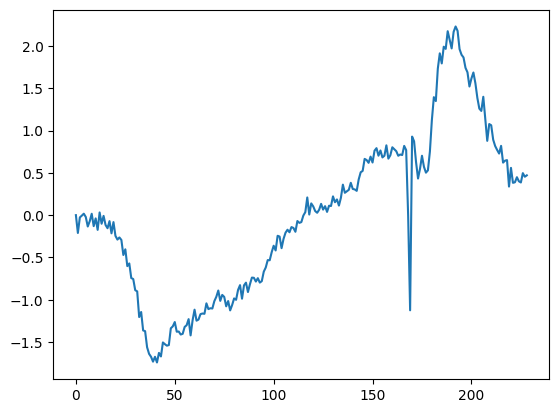

In [12]:
Supply_Demand_Indicators_df['Labor_Tightness_Index'] = Supply_Demand_Indicators_df[[
    'Job_Openings_z', 'Hires_z', 'Quits_z']].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Tightness_Index'].plot()

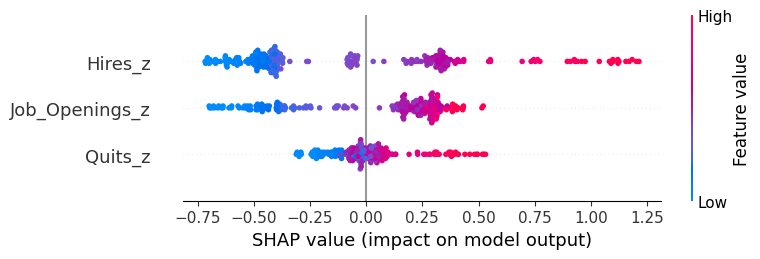

In [13]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Job_Openings_z', 'Hires_z', 'Quits_z'
]]

y = Supply_Demand_Indicators_df['Labor_Tightness_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)

### 2. **Labor Distress Index**

| **Attribute**      | **Details**                                                                                                                |
| ------------------ | -------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Highlights how many people are struggling to find full-time or stable jobs, and how competitive the market is              |
| **Components**     | Unemployed, NILFWJN, Marginally Attached, Involuntary Part-Time, Applications Pressure Proxy (z-scored)                    |
| **Formula**        | Average of `Unemployed_z`, `NILFWJN_z`, `Marginally_Attached_z`, `Involuntary_Part_Time_Rate_z`, `ApplicantsPerJobProxy_z` |
| **Interpretation** | Higher values = more underemployment, labor market slack, and congestion in job-seeking activity                           |


<Axes: >

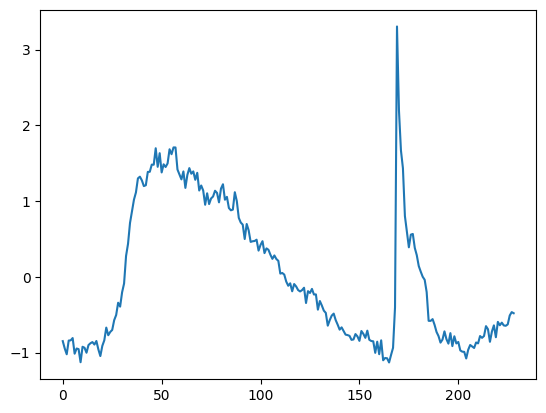

In [14]:
Supply_Demand_Indicators_df['Labor_Distress_Index'] = Supply_Demand_Indicators_df[[
    'Unemployed_z', 'NILFWJN_z', 'Marginally_Attached_z', 'Involuntary_Part_Time_Rate_z', 'ApplicantsPerJobProxy_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Distress_Index'].plot()

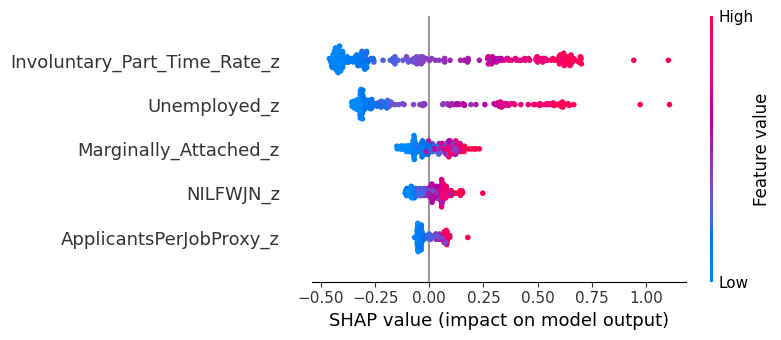

In [15]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Unemployed_z', 'NILFWJN_z', 'Marginally_Attached_z', 'Involuntary_Part_Time_Rate_z', 'ApplicantsPerJobProxy_z'
]]

y = Supply_Demand_Indicators_df['Labor_Distress_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)

### 3. **Hiring Friction Index**

| **Attribute**      | **Details**                                                                          |
| ------------------ | ------------------------------------------------------------------------------------ |
| **Purpose**        | Shows how hard it is for companies to actually hire workers                          |
| **Components**     | Openings per Hire, Hires per Unemployed (inverse), Layoffs per Opening (z-scored)    |
| **Formula**        | Average of `OpeningsPerHire_z`, `HiresPerUnemployed_z`, `LayoffsPerOpening_z`        |
| **Interpretation** | Higher values = jobs are staying open longer or it's harder to find the right people |


<Axes: >

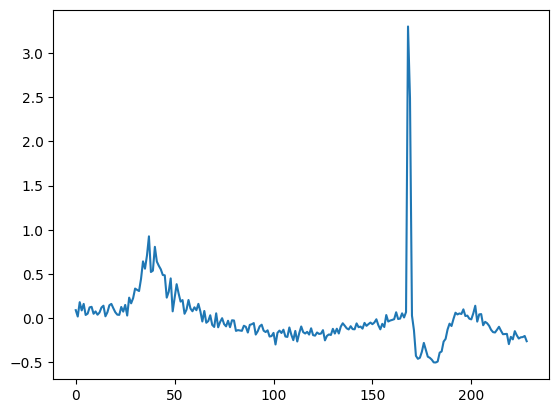

In [16]:
Supply_Demand_Indicators_df['OpeningsPerHire_z'] = zscore(Supply_Demand_Indicators_df['OpeningsPerHire'], nan_policy='omit')
Supply_Demand_Indicators_df['HiresPerUnemployed_z'] = zscore(Supply_Demand_Indicators_df['HiresPerUnemployed'], nan_policy='omit')
Supply_Demand_Indicators_df['LayoffsPerOpening_z'] = zscore(Supply_Demand_Indicators_df['LayoffsPerOpening'], nan_policy='omit')

Supply_Demand_Indicators_df['Hiring_Friction_Index'] = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'LayoffsPerOpening_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Hiring_Friction_Index'].plot()

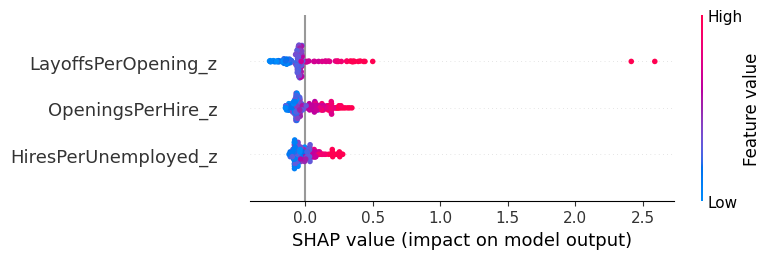

In [17]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'LayoffsPerOpening_z'

]]

y = Supply_Demand_Indicators_df['Hiring_Friction_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 4. **Hiring Latency Index**

| **Attribute**      | **Details**                                                                                                                                       |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Measures **how long it takes** for job openings to turn into hires — a proxy for hiring delay or responsiveness in the labor market               |
| **Components**     | Openings per Hire (z-scored), Hires per Unemployed (inverse z-score), Median Weeks Unemployed (z-scored)                                          |
| **Formula**        | `+ OpeningsPerHire_z`<br>`– HiresPerUnemployed_z`<br>`+ MedianWeeksUnemployed_z`                                                                  |
| **Interpretation** | Higher values = **longer hiring times** — employers take longer to fill jobs, job seekers wait longer for offers, and hiring pipelines are slower |

<Axes: >

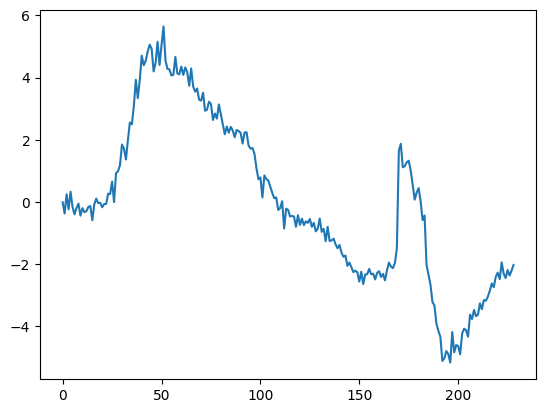

In [18]:
Supply_Demand_Indicators_df['MedianWeeksUnemployed_z'] = zscore(Supply_Demand_Indicators_df['MedianWeeksUnemployed'], nan_policy='omit')
Supply_Demand_Indicators_df['OpeningsPerHire_z'] = zscore(Supply_Demand_Indicators_df['OpeningsPerHire'], nan_policy='omit')

Supply_Demand_Indicators_df['Hiring_Latency_Index'] = (
    + Supply_Demand_Indicators_df['OpeningsPerHire_z']
    - Supply_Demand_Indicators_df['HiresPerUnemployed_z']
    + Supply_Demand_Indicators_df['MedianWeeksUnemployed_z']
)

Supply_Demand_Indicators_df['Hiring_Latency_Index'].plot()


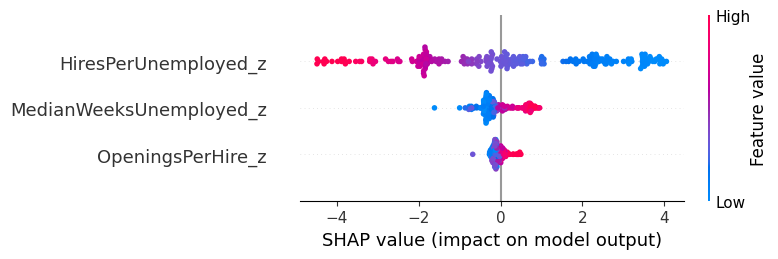

In [19]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'OpeningsPerHire_z', 'HiresPerUnemployed_z', 'MedianWeeksUnemployed_z'

]]

y = Supply_Demand_Indicators_df['Hiring_Latency_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 5. **Compensation Pressure Index**

| **Attribute**      | **Details**                                                                                                        |
| ------------------ | ------------------------------------------------------------------------------------------------------------------ |
| **Purpose**        | Measures how much wage pressure employers face due to rising hourly pay and increased workforce participation      |
| **Components**     | Implied Hourly Earnings, Real Wage Growth (YoY), Median Hourly Wage Growth, Prime-Age EPOP — all z-scored          |
| **Formula**        | Average of `HourlyEarningsEstimate_z`, `RealAvgWeeklyEarningsYoY_z`, `MedianHourlyWageGrowth3MMA_z`, `PrimeETPR_z` |
| **Interpretation** | Higher values = stronger wage pressure and tighter labor cost conditions for employers                             |


<Axes: >

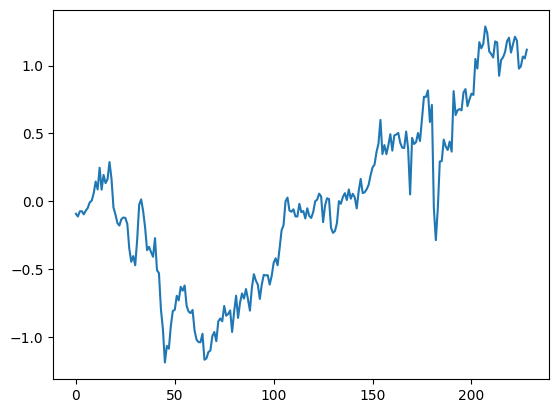

In [20]:
Supply_Demand_Indicators_df['HourlyEarningEstimate_z'] = zscore(Supply_Demand_Indicators_df['HourlyEarningEstimate'], nan_policy='omit')
Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY_z'] = zscore(Supply_Demand_Indicators_df['RealAvgWeeklyEarningsYoY'], nan_policy='omit')
Supply_Demand_Indicators_df['MedianHourlyWageGrowth3MMA_z'] = zscore(Supply_Demand_Indicators_df['Median_Hourly_Wage_Growth'], nan_policy='omit')
Supply_Demand_Indicators_df['PrimeETPR_z'] = zscore(Supply_Demand_Indicators_df['Prime_Employment_to_Pop_Ratio'], nan_policy='omit')

Supply_Demand_Indicators_df['Compensation_Pressure_Index'] = Supply_Demand_Indicators_df[[
    'HourlyEarningEstimate_z', 'RealAvgWeeklyEarningsYoY_z', 'MedianHourlyWageGrowth3MMA_z', 'PrimeETPR_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Compensation_Pressure_Index'].plot()

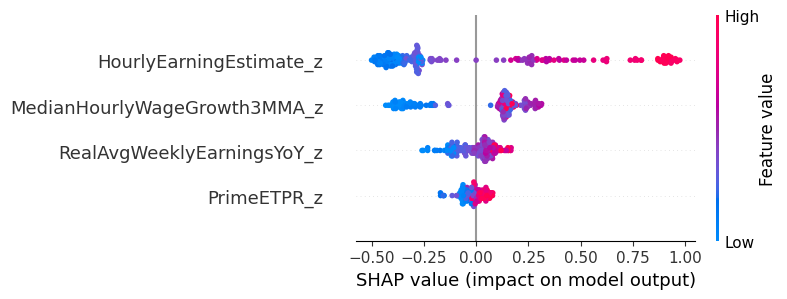

In [21]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'HourlyEarningEstimate_z', 'RealAvgWeeklyEarningsYoY_z', 'MedianHourlyWageGrowth3MMA_z', 'PrimeETPR_z'

]]

y = Supply_Demand_Indicators_df['Compensation_Pressure_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)

### 6. **Labor Market Flow Index**

| **Attribute**      | **Details**                                                                                    |
| ------------------ | ---------------------------------------------------------------------------------------------- |
| **Purpose**        | Captures how much people are switching jobs or being hired/fired                               |
| **Components**     | Quits Rate, Quits-to-Layoffs Ratio, Total Separations, Temp Help Employment YoY (z-scored)     |
| **Formula**        | Average of `QuitsRate_z`, `QuitsPerLayoffs_z`, `TotalSeperations_z`, `TempHelpEmploymentYoY_z` |
| **Interpretation** | Higher values = high job movement, worker confidence, and a busy labor market                  |


<Axes: >

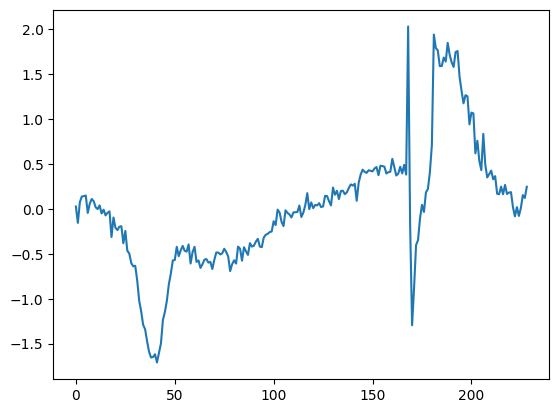

In [22]:
Supply_Demand_Indicators_df['QuitsRate_z'] = zscore(Supply_Demand_Indicators_df['Quits_Rate'], nan_policy='omit')
Supply_Demand_Indicators_df['QuitsPerLayoffs_z'] = zscore(Supply_Demand_Indicators_df['QuitsPerLayoffs'], nan_policy='omit')
Supply_Demand_Indicators_df['TotalSeperations_z'] = zscore(Supply_Demand_Indicators_df['Total_Seperations'], nan_policy='omit')
Supply_Demand_Indicators_df['TempHelpEmploymentYoY_z'] = zscore(Supply_Demand_Indicators_df['TempHelpEmploymentYoY'], nan_policy='omit')

Supply_Demand_Indicators_df['Labor_Market_Flow_Index'] = Supply_Demand_Indicators_df[[
    'QuitsRate_z', 'QuitsPerLayoffs_z', 'TotalSeperations_z', 'TempHelpEmploymentYoY_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Labor_Market_Flow_Index'].plot()

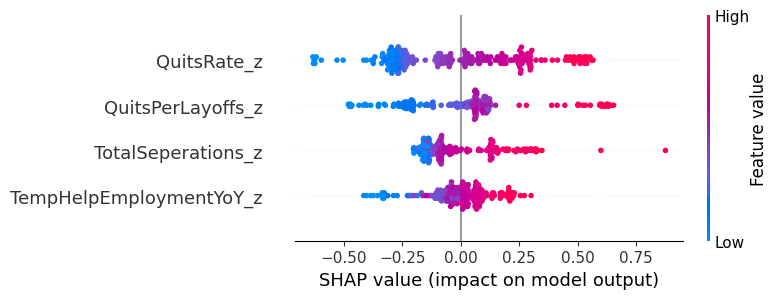

In [23]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'QuitsRate_z', 'QuitsPerLayoffs_z', 'TotalSeperations_z', 'TempHelpEmploymentYoY_z'
]]

y = Supply_Demand_Indicators_df['Labor_Market_Flow_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Drop rows with any NaNs in X or y
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data[y.name]

model.fit(X_clean, y_clean)



# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_clean)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X_clean)


In [24]:
# Step 5: Create SHAP DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_clean.columns)
shap_df['prediction'] = model.predict(X_clean)
shap_df['true_y'] = y_clean.reset_index(drop=True)
shap_df['base_value'] = shap_values.base_values

# Optional: Include feature values for context
features_df = X_clean.reset_index(drop=True)
final_df = pd.concat([features_df, shap_df], axis=1)

# View a sample
final_df
# Export to CSV (optional)
# final_df.to_csv("shap_results_labor_market.csv", index=False)


,QuitsRate_z,QuitsPerLayoffs_z,TotalSeperations_z,TempHelpEmploymentYoY_z,QuitsRate_z,QuitsPerLayoffs_z,TotalSeperations_z,TempHelpEmploymentYoY_z,prediction,true_y,base_value
0,0.151389,-0.087124,0.110393,-0.022119,0.018868,0.092559,-0.080990,0.008615,0.043352,0.038135,0.004299
1,0.029418,-0.321401,0.150793,-0.066132,-0.043344,0.020043,-0.050315,0.008717,-0.060599,-0.051830,0.004299
2,0.169826,-0.193534,0.174841,-0.190722,0.005092,0.056819,-0.052093,-0.018638,-0.004521,-0.009897,0.004299
3,0.028000,-0.113158,-0.012732,-0.196169,-0.054464,0.101832,-0.088795,-0.012934,-0.050061,-0.073515,0.004299
4,0.086149,-0.148741,0.099812,-0.213690,-0.003133,0.069078,-0.086176,-0.017664,-0.033597,-0.044118,0.004299
...,...,...,...,...,...,...,...,...,...,...,...
212,0.201028,0.171309,-0.032932,-0.656445,0.024994,0.093584,-0.106906,-0.074171,-0.058200,-0.079260,0.004299
213,0.290378,0.360970,-0.037741,-0.577122,0.062825,0.107357,-0.089110,-0.064796,0.020576,0.009121,0.004299
214,0.518718,0.516016,0.145022,-0.569531,0.159347,0.094434,-0.049764,-0.064816,0.143500,0.152556,0.004299
215,0.510209,0.312112,0.187346,-0.527946,0.156956,0.088708,-0.043993,-0.059187,0.146783,0.120430,0.004299


### 7. **Latent Labor Slack Index**

| **Attribute**      | **Details**                                                                                              |
| ------------------ | -------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Shows how much hidden or overlooked labor force is out there (people who want jobs but aren’t counted)   |
| **Components**     | NILFWJN / Pop, Marginally Attached / NILF, Involuntary Part-Time, U6–U3 Spread (z-scored)                |
| **Formula**        | Average of `NILFWJNPerPop_z`, `MarginallyAttachedPerNILF_z`, `Involuntary_Part_Time_z`, `U6_U3_Spread_z` |
| **Interpretation** | Higher values = more hidden slack in the labor market not seen in official unemployment numbers          |


<Axes: >

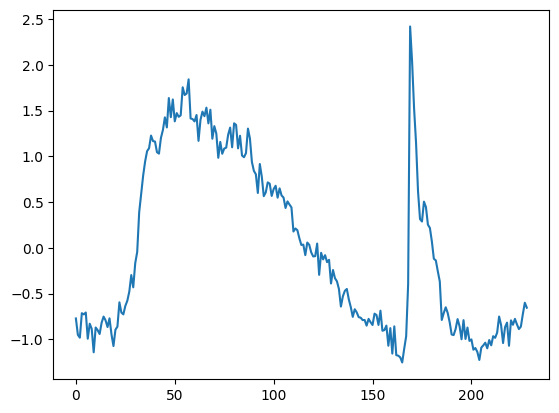

In [25]:
Supply_Demand_Indicators_df['NILFWJNPerPop_z'] = zscore(Supply_Demand_Indicators_df['NILFWJNPerPop'], nan_policy='omit')
Supply_Demand_Indicators_df['MarginallyAttachedPerNILF_z'] = zscore(Supply_Demand_Indicators_df['MarginallyAttachedPerNILF'], nan_policy='omit')
Supply_Demand_Indicators_df['Involuntary_Part_Time_z'] = zscore(Supply_Demand_Indicators_df['Involuntary_Part_Time'], nan_policy='omit')
Supply_Demand_Indicators_df['U6_U3_Spread_z'] = zscore(Supply_Demand_Indicators_df['U6_U3_Spread'], nan_policy='omit')

Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'] = Supply_Demand_Indicators_df[[
    'NILFWJNPerPop_z', 'MarginallyAttachedPerNILF_z', 'Involuntary_Part_Time_z', 'U6_U3_Spread_z'
]].mean(axis=1, skipna=True)

Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'].plot()

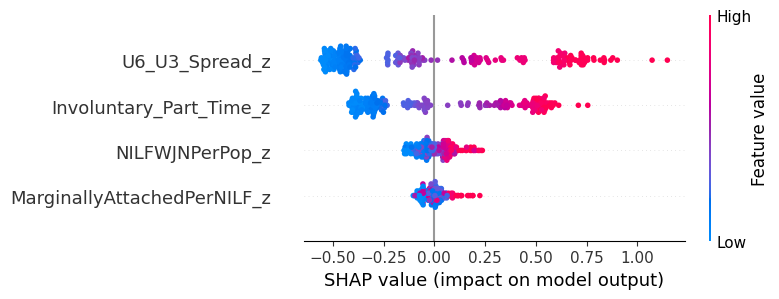

In [26]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'NILFWJNPerPop_z', 'MarginallyAttachedPerNILF_z', 'Involuntary_Part_Time_z', 'U6_U3_Spread_z'
]]

y = Supply_Demand_Indicators_df['Latent_Labor_Slack_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)


# **Market Freeze Index** &/or **Market Imbalance Index**

### 1. **Market Freeze Index**
| **Attribute**      | **Details**                                                                                                                                                                                                         |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Captures the **overall stress or "freeze"** in the labor market by combining signals of slack, weak demand, and low mobility                                                                                        |
| **Components**     | Labor Distress Index, Labor Tightness Index, Demand-Supply Gap Index, Hiring Friction Index, Compensation Pressure Index, Labor Market Flow Index, Latent Labor Slack Index                                         |
| **Formula**        | `+ Labor_Distress_Index`<br>`– Labor_Tightness_Index`<br>`– Demand_Supply_Gap_Index`<br>`+ Hiring_Friction_Index`<br>`+ Hiring_Latency_Index`<br>`– Compensation_Pressure_Index`<br>`– Labor_Market_Flow_Index`<br>`+ Latent_Labor_Slack_Index` |
| **Interpretation** | Higher values = labor market is "frozen": jobs are hard to fill, wages aren't rising, workers aren't moving, and hidden slack is growing                                                                            |


<Axes: title={'center': 'Market Freeze Index (Z-Scored)'}>

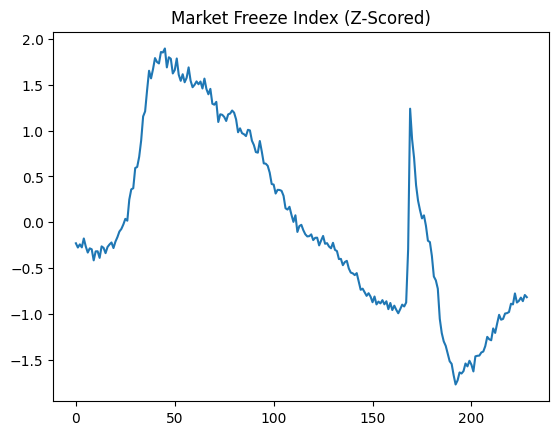

In [27]:
from scipy.stats import zscore

Supply_Demand_Indicators_df['Market_Freeze_Index'] = (
    + Supply_Demand_Indicators_df['Labor_Distress_Index']
    - Supply_Demand_Indicators_df['Labor_Tightness_Index']
    + Supply_Demand_Indicators_df['Hiring_Friction_Index']
    + Supply_Demand_Indicators_df['Hiring_Latency_Index']
    - Supply_Demand_Indicators_df['Compensation_Pressure_Index']
    - Supply_Demand_Indicators_df['Labor_Market_Flow_Index']
    + Supply_Demand_Indicators_df['Latent_Labor_Slack_Index']
)

# Optionally z-score the result if you want standardized output
Supply_Demand_Indicators_df['Market_Freeze_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Market_Freeze_Index'], nan_policy='omit'
)

# Plot it
Supply_Demand_Indicators_df['Market_Freeze_Index_z'].plot(title='Market Freeze Index (Z-Scored)')


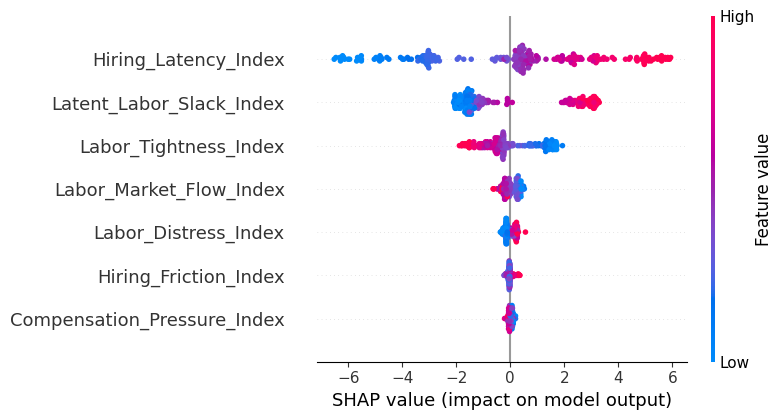

In [28]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
    'Labor_Distress_Index',
    'Labor_Tightness_Index',
    'Hiring_Friction_Index',
    'Hiring_Latency_Index',
    'Compensation_Pressure_Index',
    'Labor_Market_Flow_Index',
    'Latent_Labor_Slack_Index'
]]

y = Supply_Demand_Indicators_df['Market_Freeze_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)


### 2. **Market Imbalance Index**

| **Attribute**      | **Details**                                                                                                                                                                                                      |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Purpose**        | Quantifies the **net imbalance between employer demand and labor supply slack**, offering a cleaner alternative to the original gap metric                                                                       |
| **Components**     | Combines the Demand Index and Supply Friction Index above                                                                                                                                                        |
| **Formula**        | `+ Labor_Tightness_Index`<br>`+ Compensation_Pressure_Index`<br>`+ Labor_Market_Flow_Index`<br>`– Labor_Distress_Index`<br>`– Latent_Labor_Slack_Index`<br>`– Hiring_Friction_Index`<br>`– Hiring_Latency_Index` |
| **Interpretation** | Higher values = **tight labor conditions** with strong demand and minimal friction/slack; lower values suggest growing mismatch, drag, or recessionary conditions                                                |


<Axes: title={'center': 'Market Imbalance Index (Z-Scored)'}>

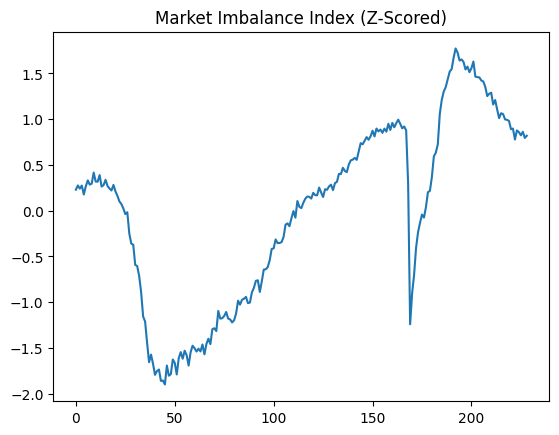

In [29]:
from scipy.stats import zscore

Supply_Demand_Indicators_df['Market_Imbalance_Index'] = (
    Supply_Demand_Indicators_df['Labor_Tightness_Index'] +
    Supply_Demand_Indicators_df['Compensation_Pressure_Index'] +
    Supply_Demand_Indicators_df['Labor_Market_Flow_Index']
    -
    Supply_Demand_Indicators_df['Labor_Distress_Index'] -
    Supply_Demand_Indicators_df['Latent_Labor_Slack_Index'] -
    Supply_Demand_Indicators_df['Hiring_Friction_Index'] -
    Supply_Demand_Indicators_df['Hiring_Latency_Index']
)

# Optionally z-score the result if you want standardized output
Supply_Demand_Indicators_df['Market_Imbalance_Index_z'] = zscore(
    Supply_Demand_Indicators_df['Market_Imbalance_Index'], nan_policy='omit'
)

# Plot it
Supply_Demand_Indicators_df['Market_Imbalance_Index_z'].plot(title='Market Imbalance Index (Z-Scored)')

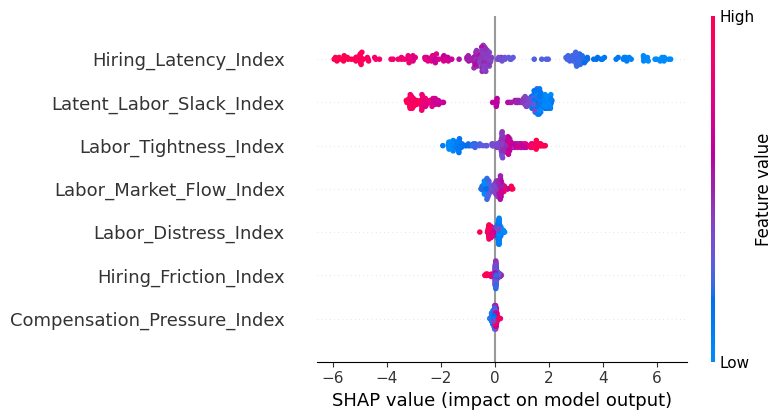

In [30]:
import pandas as pd
import shap
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Step 1: Select features and target
X = Supply_Demand_Indicators_df[[
   'Labor_Distress_Index',
    'Labor_Tightness_Index',
    'Hiring_Friction_Index',
    'Hiring_Latency_Index',
    'Compensation_Pressure_Index',
    'Labor_Market_Flow_Index',
    'Latent_Labor_Slack_Index'
]]

y = Supply_Demand_Indicators_df['Market_Imbalance_Index']

# Step 2: Fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 4: Plot feature importance
shap.summary_plot(shap_values, X)


# **Summaries of each graph using Tableau**


---

### **Image 1: Demand-Side (Heat/Pressure)**

#### **Indices Tracked**:

* **Compensation Pressure Index (Blue)**: Tracks wage pressure from rising pay, wage growth, and workforce participation.
* **Labor Market Flow Index (Red)**: Measures job movement (quits, layoffs, temp hiring).
* **Labor Tightness Index (Orange)**: Reflects competition for workers and hiring confidence.

#### **Key Takeaways**:

* All three indices dip significantly during the 2008–2009 recession and again during COVID-19 (2020).
* Post-2020 shows a spike, particularly in **Labor Tightness** and **Compensation Pressure**, indicating a hot labor market.
* 2023–2025 shows some cooling, especially in job flows and tightness, but compensation pressures remain moderately elevated.
<img src="Demand-Side.png" alt="Frozen Market Index" width="900"/>

---

### **Image 2: Supply-Side (Slack/Friction)**

#### **Indices Tracked**:

* **Labor Distress Index (Red)**: High values reflect underemployment and job market congestion.
* **Hiring Friction Index (Blue)**: Captures mismatch in filling open roles.
* **Hiring Latency Index (Orange)**: Shows delays between job postings and hires.
* **Latent Labor Slack Index (Green)**: Proxy for hidden slack like part-time underemployment.

#### **Key Takeaways**:

* **Labor Distress** peaked post-2008 and briefly in 2020, consistent with downturns.
* **Friction and latency** have remained mildly elevated post-COVID, indicating slower employer responsiveness.
* **Latent slack** is relatively stable, but overall supply-side pressure eased significantly after the COVID spike.
<img src="Supply-Side.png" alt="Frozen Market Index" width="900"/>

---

### **Image 3: Composite — Frozen Market Index**

#### **Panel View**:

* Combines both **Supply-Side** and **Demand-Side** components.
* **Frozen Market Index** shown on the right plots a z-scored composite from 2006 to 2025.

#### **Key Takeaways**:

* Index spikes in 2009 and again in 2020, aligning with major labor market disruptions.
* Sustained downward trend from 2010 to 2019 indicates a more fluid and healthier labor market.
* Post-COVID freeze was short but sharp, with recovery ongoing into 2025.
* The index serves as an effective real-time signal of labor market dysfunction.
<img src="Overall.png" alt="Frozen Market Index" width="900"/>

---

### **Image 4: Frozen Market Index Only**

#### **Description**:

* Isolated view of the **Frozen Market Index** from 2006–2025.

#### **Key Takeaways**:

* Confirms the dual peaks in market freeze during the 2008 Great Recession and the 2020 COVID crisis.
* Shows recovery arcs post-recession, with 2023–2025 levels still below zero, indicating gradual return to market normalcy.
* Helpful for visualizing long-term labor market thawing after major freezes.

<img src="Frozen_Market_Index.png" alt="Frozen Market Index" width="400"/>

---

Let me know if you’d like to annotate these trends directly on the visuals or incorporate this summary into a presentation/report.


